# Synthetic data test: Proof of concept

The main goal of this synthetic is to show that the method works better than Euler Deconvolution. It will show how the solution converges. This is also the first synthetic that will be shown in the paper.

In [1]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler

## Create a model and data

Make a model from a dipole. Add an interfering source at the edge of the region and some gaussian random noise.

Number of data: 5712


/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


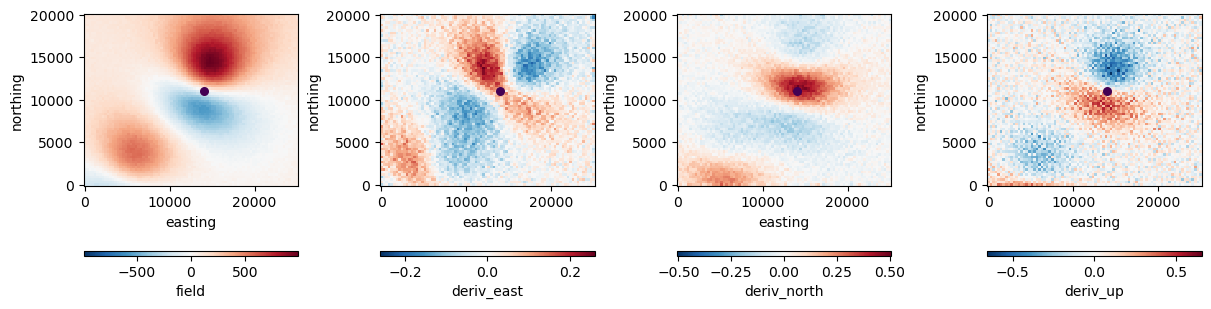

In [2]:
region = [0, 25e3, 0, 20e3]
coordinates = vd.grid_coordinates(region, spacing=300, extra_coords=800)
inclination, declination = -30, 15
base_level = 100
true_coordinates = (14e3, 11e3, -5e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=true_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
    field="b",
)
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))

# Interfering source
other = hm.dipole_magnetic(
    coordinates,
    dipoles=(5e3, 0e3, -6e3),
    magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(other, main_field))

# Add noise and the base level
magnetic_anomaly += np.random.default_rng(42).normal(0, 10, size=magnetic_anomaly.shape)
magnetic_anomaly += base_level

print(f"Number of data: {magnetic_anomaly.size}")

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(
    coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"]
)
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

fig, axes = plt.subplots(1, 4, figsize=(12, 5), layout="constrained")
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(
        ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50)
    )
    ax.set_aspect("equal")
    tmp = ax.scatter(*true_coordinates[:2], c=true_coordinates[2], s=30)
plt.show()

## Euler Deconvolution

In [3]:
%%time
ed = euler.EulerDeconvolution(structural_index=3).fit_grid(data)
print("Base level:")
print(f"  True      = {base_level}")
print(f"  Estimated = {ed.base_level_}")
print("Position:")
print(f"  True      = {true_coordinates}")
print(f"  Estimated = {ed.location_}")
print(f"  STD       = {np.sqrt(np.diag(ed.covariance_))}")

Base level:
  True      = 100
  Estimated = 99.91685649935073
Position:
  True      = (14000.0, 11000.0, -5000.0)
  Estimated = [11867.85299002  9261.62962379 -2984.21162403]
  STD       = [134.41236708  92.13484176  60.8116146    2.92319702]
CPU times: user 2.03 ms, sys: 0 ns, total: 2.03 ms
Wall time: 1.95 ms


## Euler Inversion

In [4]:
%%time
ei = euler.EulerInversion(structural_index=3).fit_grid(
    data, weights=(1, 0.1, 0.1, 0.05)
)
print("Base level:")
print(f"  True      = {base_level}")
print(f"  Estimated = {ei.base_level_}")
print("Position:")
print(f"  True      = {true_coordinates}")
print(f"  Estimated = {ei.location_}")
print(f"  STD       = {np.sqrt(np.diag(ei.covariance_))}")

Base level:
  True      = 100
  Estimated = 120.80923155511819
Position:
  True      = (14000.0, 11000.0, -5000.0)
  Estimated = [13644.43759558 10739.09348767 -4632.75269588]
  STD       = [226.5772343  145.42859382 105.25077908   5.52187235]
CPU times: user 368 ms, sys: 3.01 ms, total: 371 ms
Wall time: 34.3 ms


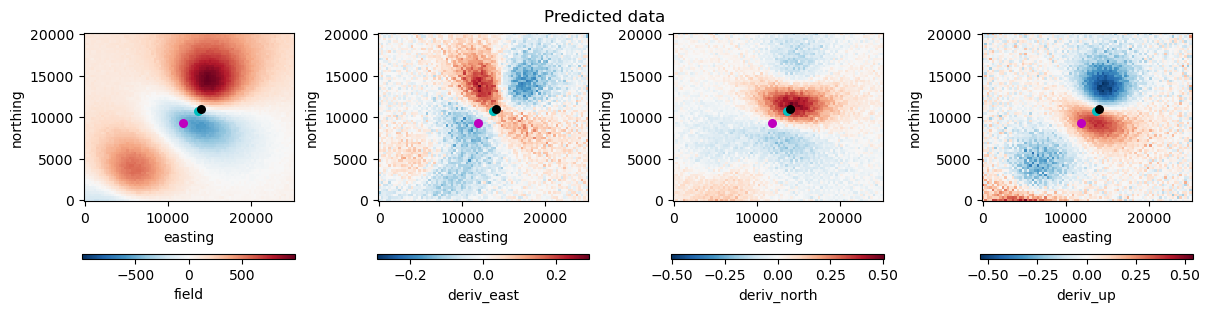

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3), layout="constrained")
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    ei.predicted_grid_[field].plot.pcolormesh(
        ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50)
    )
    ax.set_aspect("equal")
    tmp = ax.scatter(*ei.location_[:2], c="c", s=30)
    tmp = ax.scatter(*ed.location_[:2], c="m", s=30)
    tmp = ax.scatter(*true_coordinates[:2], c="k", s=30)
fig.suptitle("Predicted data")
plt.show()

## Make a figure

Show the observed and predicted data, estimates, and progress per iteration.

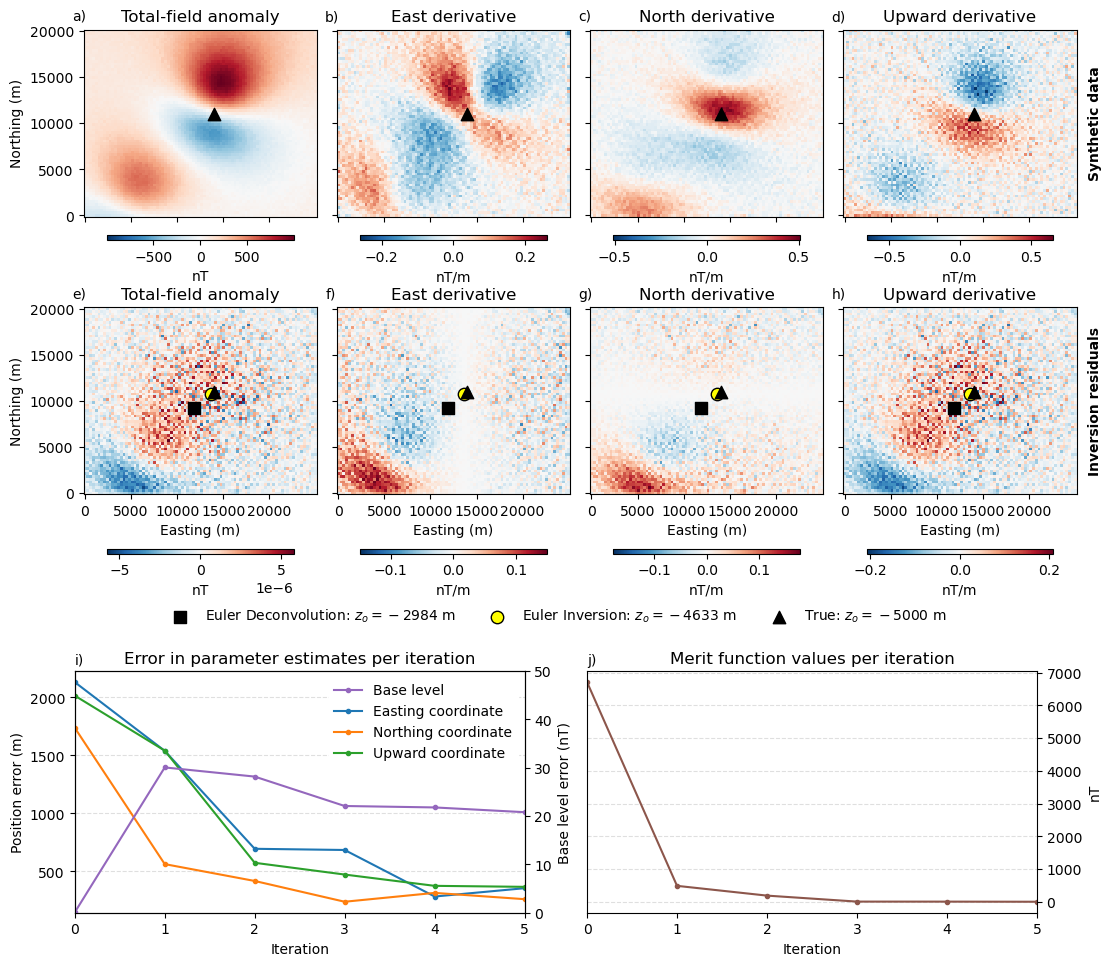

In [6]:
estimates = np.array(ei.location_per_iteration_)
east_error = np.abs(true_coordinates[0] - estimates[:, 0])
north_error = np.abs(true_coordinates[1] - estimates[:, 1])
up_error = np.abs(true_coordinates[2] - estimates[:, 2])
base_levels = np.array(ei.base_level_per_iteration_)
base_error = np.abs(base_level - base_levels)

colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])

fig = plt.figure(figsize=(11, 9.5), layout="constrained")
figures = fig.subfigures(2, 1, height_ratios=[2, 1])

axes = figures[0].subplots(2, 4, sharey=True, sharex=True)

marker_size = 80
cbkwargs = dict(orientation="horizontal", aspect=40, shrink=0.8)
units = {"field": "nT", "deriv_east": "nT/m", "deriv_north": "nT/m", "deriv_up": "nT/m"}
data_names = {
    "field": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}
for field, ax, label in zip(
    ["field", "deriv_east", "deriv_north", "deriv_up"], axes[0, :].ravel(), "abcd"
):
    ax.set_aspect("equal")
    tmp = data[field].plot.pcolormesh(ax=ax, add_labels=False, add_colorbar=False)
    fig.colorbar(tmp, ax=ax, label=units[field], **cbkwargs)
    ax.scatter(
        *true_coordinates[:2],
        c="k",
        s=marker_size,
        marker="^",
        linewidths=1,
        edgecolors="black",
    )
    ax.set_title(data_names[field])
for field, ax in zip(
    ["field", "deriv_east", "deriv_north", "deriv_up"], axes[1, :].ravel()
):
    ax.set_aspect("equal")
    ax.set_title(data_names[field])
    tmp = (data[field] - ei.predicted_grid_[field]).plot.pcolormesh(
        ax=ax, add_labels=False, add_colorbar=False
    )
    fig.colorbar(tmp, ax=ax, label=units[field], **cbkwargs)
    inv = ax.scatter(
        *ei.location_[:2],
        c="yellow",
        s=marker_size,
        marker="o",
        linewidths=1,
        edgecolors="black",
    )
    deconv = ax.scatter(
        *ed.location_[:2],
        c="k",
        s=marker_size,
        marker="s",
        linewidths=1,
        edgecolors="black",
    )
    true = ax.scatter(
        *true_coordinates[:2],
        c="k",
        s=marker_size,
        marker="^",
        linewidths=1,
        edgecolors="black",
    )
figures[0].legend(
    [deconv, inv, true],
    [
        f"Euler Deconvolution: $z_o = {ed.location_[-1]:.0f}$ m",
        f"Euler Inversion: $z_o = {ei.location_[-1]:.0f}$ m",
        f"True: $z_o = {true_coordinates[-1]:.0f}$ m",
    ],
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    ncols=3,
    loc="outside lower center",
)
for ax in axes[1, :]:
    ax.set_xticks(np.arange(0, 25e3, 5e3))
for ax in axes[:, 0]:
    ax.set_ylabel("Northing (m)")
for ax in axes[1, :]:
    ax.set_xlabel("Easting (m)")
axes[0, -1].yaxis.set_label_position("right")
axes[0, -1].set_ylabel("Synthetic data", fontweight="bold", labelpad=8)
axes[1, -1].yaxis.set_label_position("right")
axes[1, -1].set_ylabel("Inversion residuals", fontweight="bold", labelpad=8)
for ax, label in zip(axes.ravel(), "abcdefgh"):
    ax.text(-0.05, 1.05, f"{label})", transform=ax.transAxes)

ax1, ax2 = figures[1].subplots(1, 2)

ax1.grid(axis="y", alpha=0.4, linestyle="--")
(east,) = ax1.plot(east_error, color=colors[0], marker=".", linestyle="-")
(north,) = ax1.plot(north_error, color=colors[1], marker=".", linestyle="-")
(up,) = ax1.plot(up_error, color=colors[2], marker=".", linestyle="-")
twin = ax1.twinx()
(base,) = twin.plot(base_error, color=colors[4], marker=".", linestyle="-")
ax1.legend(
    [base, east, north, up],
    ["Base level", "Easting coordinate", "Northing coordinate", "Upward coordinate"],
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
)
twin.set_ylim(0, base_level / 2)
twin.set_ylabel("Base level error (nT)")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Position error (m)")
ax1.set_title("Error in parameter estimates per iteration")
ax1.set_xlim(0, len(east_error) - 1)

ax2.grid(axis="y", alpha=0.4, linestyle="--")
ax2.plot(ei.merit_, label="Merit", color=colors[5], marker=".", linestyle="-")

ax2.set_xlabel("Iteration")
ax2.set_ylabel("nT")
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_title("Merit function values per iteration")
ax2.set_xlim(0, len(east_error) - 1)

for ax, label in zip([ax1, ax2], "ij"):
    ax.text(0, 1.03, f"{label})", transform=ax.transAxes)

for dpi, res in zip([70, 300], ["", "-highres"]):
    fig.savefig(
        f"../paper/figures/synthetic-proof-of-concept{res}.png",
        dpi=dpi,
        bbox_inches="tight",
    )

plt.show()